# Lokalizacja punktu na płaszczyźnie dwuwymiarowej – metoda trapezowa 

### Treść zadania

Dany jest obszar z podziałem poligonowym. Zadawany jest punkt P na płaszczyźnie. Należy
zaimplementować algorytm lokalizacji punktu metodą trapezową, który odpowie na pytanie,
w którym elemencie znajduje się dany punkt. (Należy także umożliwić użytkownikowi
odpowiednio zadawanie obszaru z podziałem poligonowym.) 
Zrobić analizę efektywności algorytmu.

Program powinien w sposób graficzny prezentować etapy algorytmu dla wybranych
przykładów (w celu objaśnienia działania algorytmu). Program ma służyć jako narzędzie
dydaktyczne do objaśnienia działania algorytmu. 

### Realizacja projektu

### Dane:
Poligonowy podział płaszczyzny oraz punkt P należący do zadanej płaszczyzny.

### Cel:
Odszukanie wielokąta (ściany) zawierającego zadany punkt w czasie optymalnym -> $O(nlogn)$.

#### Uwaga: 
Istnieją ustawienia, które nie pozwolą nam jednoznacznie wskazać, do którego wielokąta możemy przypisać punkt P (nie będzie on leżał wewnątrz żadnej ze ścian). W celu pokrycia takiego przypadku brzegowego, umieszczamy cały podział w prostokącie zawierającym całą płaszczynę planarną. Prosotkąt ten będzie nazywać $B$. W wypadku wystąpienia wcześniej opsianego przypadku brzegowego, algorytm zwróci obszar opisanego prostokąta $B$.


## Metoda trapezowa
Podział płaszczyzny będzie reprezentowany przez zbiór odcinków $S$ = {$s$<sub>1</sub>,$s$<sub>2</sub>,...,$s$<sub>n</sub>}, o następujących założeniach:
- wartości współrzędnej x początku i końca odcinka dla żadnego odcinka nie są takie same, innymi słowy zbiór nie zawiera odcników pionowych,
- żadne dwa odcinki nie przecinają się, poza ewentualnie nachodzącymi na siebie wierzchołkami,
- wierzchołki żadnych dwóch odcinków nie mają takiej samej współrzędnej x (poza ewentualnymi końcami połączonych odcinków).

W celu realizacji algorytmu wprowadzimy nową strukturę odpowiedzialną za reprezentację płaszczyzny - Mapę trapezową.
### Mapa trapezowa
Mapa trapezowa $T$($S$) jest podziałem $S$ na trapezy (prawidłowe lub zdegenerowane) otrzymanym przez poprowadzenie dwóch odcinków pionowych z każdego końca odcinka w $S$. Rozszerzenia kończą się, gdy napotkają inny odcinek $S$ lub brzeg prostokąta $B$. 

### Wykorzystywane struktury danych

Oprócz wskazanej wcześniej struktury Mapy tapezowej, implementację uzupełniono o realizację opartą o następujących strukturach

### Point

Struktura odpowiedzialna za obsługę pojedynczych punktów i ich informacji

In [1]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def __gt__(self, other):
        return self.x > other.x

    def to_tuple(self):
        return (self.x, self.y)

    def __str__(self):
        return "{},{}".format(self.x, self.y)
    
    def __hash__(self):
        return hash((self.x, self.y))

### Segment

Struktura odpowiedzialna za przetrzymywanie informacji o pojedyncznym odcinku na płaszczyźnie

In [2]:
class Segment:
    x = 0
    
    def __init__(self, point1, point2):
        if point1.x < point2.x:
            self.left = point1
            self.right = point2
        else:
            self.left = point2
            self.right = point1
            
        self.a = None
        self.b = None
        self._calculate_line_parameters()
        
    def _calculate_line_parameters(self):
        dx = self.right.x - self.left.x
        if dx != 0: 
            self.a = (self.right.y - self.left.y) / dx
            self.b = self.left.y - (self.a * self.left.x)
        else:
            self.a = float('inf')
            self.b = self.left.x

    @classmethod
    def set_reference_x(cls, x):
        cls.x = x

    def get_y(self, x):
        if self.left.x <= x <= self.right.x:
            if self.a is not None:
                if self.a == float('inf'):
                    return None
                return self.a * x + self.b
        return None
    
    def get_a(self):
        return self.a
    
    def get_b(self):
        return self.b
    
    def is_above(self, point):
        y_at_x = self.get_y(point.x)
        return y_at_x is not None and point.y > y_at_x

    def __lt__(self, other):
        if not isinstance(other, Segment):
            return NotImplemented
        if self.a is None or other.a is None:
            return False
        if self.a == float('inf') or other.a == float('inf'):
            return self.b < other.b
        y_self = self.get_y(Segment.x)
        y_other = other.get_y(Segment.x)
        if y_self is None or y_other is None:
            return False
        return y_self < y_other

    def __gt__(self, other):
        if not isinstance(other, Segment):
            return NotImplemented
        if self.a is None or other.a is None:
            return False
        if self.a == float('inf') or other.a == float('inf'):
            return self.b > other.b
        y_self = self.get_y(Segment.x)
        y_other = other.get_y(Segment.x)
        if y_self is None or y_other is None:
            return False
        return y_self > y_other

    def __hash__(self):
        return hash((self.left, self.right))
    
    def to_tuple(self):
        return (self.left.to_tuple(), self.right.to_tuple())
    
    def __eq__(self, other):
        if not isinstance(other, Segment):
            return False
        return self.left == other.left and self.right == other.right

    @staticmethod
    def update_x(x):
        Segment.x = x

### Trapez

Przechowuje pojedynczy odcinek należący do mapy tapezów

In [3]:
class Trapez:
    def __init__(self, top, bottom, p, q):
        self.top_segment = top
        self.bottom_segment = bottom
        self.left_point = p
        self.right_point = q

        self.top_left = None
        self.bottom_left = None
        self.top_right = None
        self.bottom_right = None
        self.node = None

    def __str__(self):
        return f"{self.bottom_segment} {self.top_segment}"
    
    def __eq__(self, other):
        if not isinstance(other, Trapez):
            return False
        return (self.top_segment == other.top_segment and 
                self.bottom_segment == other.bottom_segment and
                self.left_point == other.left_point and 
                self.right_point == other.right_point)

    def copy(self):
        new_trapez = Trapez(
            self.top_segment,
            self.bottom_segment,
            self.left_point,
            self.right_point
        )
        new_trapez.update_neighbors(
            self.top_left,
            self.top_right,
            self.bottom_left,
            self.bottom_right
        )
        new_trapez.node = self.node
        return new_trapez
    
    def split_at_point(self, point):
        if not self.left_point.x <= point.x <= self.right_point.x:
            return None, None
            
        left_trapez = Trapez(
            self.top_segment,
            self.bottom_segment,
            self.left_point,
            point
        )
        
        right_trapez = Trapez(
            self.top_segment,
            self.bottom_segment,
            point,
            self.right_point
        )
        
        return left_trapez, right_trapez

### Rectangle

Prostokąt otoczający całą płąszczyznę 

In [4]:
class Rectangle:
    @staticmethod
    def create_rectangle(lines):
        x_coords = [point[0] for line in lines for point in line]
        y_coords = [point[1] for line in lines for point in line]

        min_x = min(x_coords)
        max_x = max(x_coords)
        min_y = min(y_coords)
        max_y = max(y_coords)

        low_left = Point(min_x, min_y)
        low_right = Point(max_x, min_y)
        up_left = Point(min_x, max_y)
        up_right = Point(max_x, max_y)

        top_segment = Segment(up_left, up_right)
        bottom_segment = Segment(low_left, low_right)

        return Trapez(top_segment, bottom_segment, up_left, up_right)

### Drzewa

Zaimplementowo dwie strultury drzew, podstawową - Node i specjalnie przygotowaną do tego algorytmu - Tree
Nasze rozważania skupimy na tej drugiej
<p>Tree - Struktura umożliwiająca przeszukiwanie mapy trapezowej w celu znalezienia "ściany" do której należy zadany punkt.</p>
<p>Zawiera ona 3 typy węzłów:</p>
<ul>
    <li>l_type_node - jest to liść drzewa, który zawiera jedną ze "ścian" mapy trapezowej</li>
    <li>x_type_node - jest to węzeł typu X zawierający punkt</li>
    <li>y_type_node - jest to węzeł typu Y zawierający odcinek</li>
</ul>

In [5]:
class Node:
    def __init__(self, node_type, data):
        self.node_type = node_type
        self.data = data
        self.left = None
        self.right = None

In [6]:
class Tree:
    def __init__(self, root):
        self.root = root

    def update_root(self, root):
        self.root = root

    def query(self, node, point, segment=None):
        if node.node_type == 'l_type_node':
            return node.data
        if node.node_type == 'x_type_node':
            if point < node.data: # wybiera lewe/prawe poddrzewo w zależnosci czy jest na lewo/prawo
                return self.query(node.left, point, segment)
            else:
                return self.query(node.right, point, segment)
        else: # y-type -> odcinek
            if node.data.is_above(point):
                # punkt w górnej częsci trapezu -> lewe poddrzewo
                return self.query(node.left, point, segment)
            elif node.data.get_y(point.x) == point.y: # jeśli na odcinku
                if segment.a > node.data.a: # w zależności od nachylenia wybiera prawo/lewo
                    return self.query(node.left, point, segment)
                else:
                    return self.query(node.right, point, segment)
            else: # punkt pod odcinkiem
                return self.query(node.right, point, segment)



    @staticmethod
    # dzielenie trapezu na lewą i prawą stronę
    def update_node_both_sides(trapezoid, segment, left, top, bottom, right):
        # początek odcinek jest x_type
        node = trapezoid.node
        node.node_type = 'x_type_node'
        node.data = segment.left
        # liść dla lewej strony
        lefl_type_node = Node('l_type_node', left)
        node.left = lefl_type_node
        left.node = lefl_type_node
        # dla końca odcinka x_type
        righl_type_node = Node('x_type_node', segment.right)
        node.right = righl_type_node
        # dla prawej górnej i dolnej l_type
        right_leaf = Node('l_type_node', right)
        righl_type_node.right = right_leaf
        right.node = right_leaf
        # dla odcinka y_type
        segmenl_type_node = Node('y_type_node', segment)
        righl_type_node.left = segmenl_type_node

        top_leaf = Node('l_type_node', top)
        segmenl_type_node.left = top_leaf
        top.node = top_leaf

        bottom_leaf = Node('l_type_node', bottom)
        segmenl_type_node.right = bottom_leaf
        bottom.node = bottom_leaf

    @staticmethod
    # dzieli tylko na prawą stronę
    def update_node_right_side(trapezoid, segment, top, bottom, right):
        # x_type dla punktu
        node = trapezoid.node
        node.node_type = 'x_type_node'
        node.data = segment.right

        right_leaf = Node('l_type_node', right)
        node.right = right_leaf
        right.node = right_leaf

        segmenl_type_node = Node('y_type_node', segment)
        node.left = segmenl_type_node

        top_leaf = Node('l_type_node', top)
        segmenl_type_node.left = top_leaf
        top.node = top_leaf

        bottom_leaf = Node('l_type_node', bottom)
        segmenl_type_node.right = bottom_leaf
        bottom.node = bottom_leaf

    @staticmethod
    # dzieli tylko na lewą stronę
    def update_node_left_side(trapezoid, segment, left, top, bottom):
        node = trapezoid.node
        node.node_type = 'x_type_node'
        node.data = segment.left

        lefl_type_node = Node('l_type_node', left)
        node.left = lefl_type_node
        left.node = lefl_type_node

        segmenl_type_node = Node('y_type_node', segment)
        node.right = segmenl_type_node

        bottom_leaf = Node('l_type_node', bottom)
        segmenl_type_node.right = bottom_leaf
        bottom.node = bottom_leaf

        top_leaf = Node('l_type_node', top)
        segmenl_type_node.left = top_leaf
        top.node = top_leaf

    @staticmethod
    # bez stron( odcinek wewnątrz trapezu)
    def update_node_no_sides(trapezoid, segment, top, bottom):
        # tworzy górną i dolną część
        node = trapezoid.node
        node.node_type = 'y_type_node'
        node.data = segment
        # tworzy liście dla górnej i dolnej ściany
        top_leaf = Node('l_type_node', top)
        node.left = top_leaf
        top.node = top_leaf

        bottom_leaf = Node('l_type_node', bottom)
        node.right = bottom_leaf
        bottom.node = bottom_leaf

    @staticmethod
    # dzieli wiele trapezów na raz jeśli przechodzi przez nie odcinek
    def update_node_multiple(trapezoids, segment, new_above, new_below, left, right):
        
        if left:
            Tree.update_node_left_side(trapezoids[0], segment, left, new_above[0], new_below[0])
        
        else:
            Tree.update_node_no_sides(trapezoids[0], segment, new_above[0], new_below[0])

        node = trapezoids[0].node
        i, j = 0, 0
        
        while i + j < len(trapezoids) - 2:
            
            node = trapezoids[i + j + 1].node
            # tworzy trpez dzieląc góre i dół
            node.node_type = 'y_type_node'
            node.data = segment
            # dynamicznie decydowanie czy dzielić na górny i dolny w zależności od układu
            if i == len(new_above) - 1 or (j < len(new_below) - 1 and new_below[j].right_point < new_above[i].right_point):
                j += 1
                above_node = new_above[i].node
                below_leaf = Node('l_type_node', new_below[j])
                node.left = above_node
                node.right = below_leaf
                new_below[j].node = below_leaf
            
            else:
                i += 1
                below_node = new_below[j].node
                above_leaf = Node('l_type_node', new_above[i])
                node.right = below_node
                node.left = above_leaf
                new_above[i].node = above_leaf

        lasl_type_node = trapezoids[-1].node
        
        if right:
            lasl_type_node.node_type = 'x_type_node'
            lasl_type_node.data = segment.right
            right_leaf = Node('l_type_node', right)
            lasl_type_node.right = right_leaf
            right.node = right_leaf
            segmenl_type_node = Node('y_type_node', segment)
            lasl_type_node.left = segmenl_type_node
        
        else:
            lasl_type_node.node_type = 'y_type_node'
            lasl_type_node.data = segment

        last_above = new_above[-1].node
        last_below = new_below[-1].node
        
        if i == len(new_above) - 1 and j == len(new_below) - 1:
            lasl_type_node.left = last_above
            lasl_type_node.right = last_below
        
        elif j == len(new_below) - 1:
            last_above_leaf = Node('l_type_node', new_above[-1])
            lasl_type_node.left = last_above_leaf
            new_above[-1].node = last_above_leaf
            lasl_type_node.right = last_below
        
        else:
            last_below_leaf = Node('l_type_node', new_below[-1])
            lasl_type_node.right = last_below_leaf
            new_below[-1].node = last_below_leaf
            lasl_type_node.left = last_above


### TrapezoidMap

Tworzenie mapy i operacje na niej

In [7]:
import random
class TrapezoidMap:

    def __init__(self):
      self.tree = None

    def insertIntoOne(_, trapezoid : Trapez, segment : Segment):
        p, q = segment.left, segment.right
        bottom_left = trapezoid.bottom_left
        bottom_right = trapezoid.bottom_right
        top_left = trapezoid.top_left
        top_right = trapezoid.top_right
        
        left, right = None, None
        top = Trapez(trapezoid.top_segment, segment, p, q)
        bottom = Trapez(segment, trapezoid.bottom_segment, p, q)
        
        if trapezoid.left_point < p:
            left = Trapez(trapezoid.top_segment, trapezoid.bottom_segment, trapezoid.left_point, p)
            left.bottom_left = bottom_left
            left.top_left = top_left

            if trapezoid.top_left: trapezoid.top_left.top_right = left
            if trapezoid.bottom_left: trapezoid.bottom_left.bottom_right = left

            left.top_right = top
            left.bottom_right = bottom
            top.top_left = left
            bottom.bottom_left = left
  


        else:
            Segment.update_x(p.x)
            bottom.bottom_left = bottom_left
            top.top_left = top_left
            if bottom_left:
                bottom_left.bottom_right = bottom
                if bottom_left.top_segment > segment:
                    bottom_left.top_right = top
                    top.bottom_left = bottom_left
            if top_left:
                top_left.top_right = top
                if segment > top_left.bottom_segment:
                    top_left.bottom_right = bottom
                    bottom.top_left = top_left
                    
        if trapezoid.right_point > q:
            right = Trapez(trapezoid.top_segment, trapezoid.bottom_segment, segment.right, trapezoid.right_point)
            right.bottom_right = bottom_right
            right.top_right = top_right
            right.bottom_left = bottom
            right.top_left = top
            top.top_right = right
            bottom.bottom_right = right
            if trapezoid.top_right: trapezoid.top_right.top_left = right
            if trapezoid.bottom_right: trapezoid.bottom_right.bottom_left = right
        else:
            Segment.update_x(q.x)
            bottom.bottom_right = bottom_right
            top.top_right = top_right
            if bottom_right:
                bottom_right.bottom_left = bottom
                if bottom_right.top_segment > segment:
                    bottom_right.top_left = top
                    top.bottom_right = bottom_right
            if top_right:
                top_right.top_left = top
                if segment > top_right.bottom_segment:
                    top_right.bottom_left = bottom
                    bottom.top_right = top_right
                    
        if left and right:
            Tree.update_node_both_sides(trapezoid, segment, left, top, bottom, right)
        elif not left and right:
            Tree.update_node_right_side(trapezoid, segment, top, bottom, right)
        elif left and not right:
            Tree.update_node_left_side(trapezoid, segment, left, top, bottom)
        else:
            Tree.update_node_no_sides(trapezoid, segment, top, bottom)
    def insertIntoMany (_, trapezoids: list[Trapez], segment: Segment):
        p, q = segment.left, segment.right
        left, right = None, None
        newTrapezoidsAbove = []
        newTrapezoidsBelow = []
        n = len(trapezoids)
        first = trapezoids[0]
        bottom_left = first.bottom_left
        top_left = first.top_left
        top_right = first.top_right
        bottom_right = first.bottom_right
        Segment.update_x(first.right_point.x)
        
        if segment.is_above(first.right_point):
            top = Trapez(first.top_segment, segment, p, first.right_point)
            bottom = Trapez(segment, first.bottom_segment, p, Point(Segment.x, segment.get_y(Segment.x)))
            merge = "lower"
        else:
            top = Trapez(first.top_segment, segment, p, Point(Segment.x, segment.get_y(Segment.x)))
            bottom = Trapez(segment, first.bottom_segment, p, first.right_point)
            merge = "upper"
            
        if first.left_point < p:
            left = Trapez(first.top_segment, first.bottom_segment, first.left_point, p)
            left.bottom_left = bottom_left
            left.top_left = top_left
            left.top_right = top
            left.bottom_right = bottom
            top.top_left = left
            bottom.bottom_left = left 
            if first.top_left: first.top_left.top_right = left
            if first.bottom_left: first.bottom_left.bottom_right = left
            
            
        else:           
            bottom.bottom_left = bottom_left
            top.top_left = top_left
            if bottom_left:
                bottom_left.bottom_rightt = bottom
                if bottom_left.top_segment > segment:
                    bottom_left.top_right = top
                    top.bottom_left = bottom_left
            if top_left:
                top_left.top_right = top
                if segment > top_left.bottom_segment:
                    top_left.bottom_right = bottom
                    bottom.top_left = top_left
                                
        if trapezoids[1] == first.bottom_right:
            top.top_right = top_right
            if top_right:
                top_right.top_left = top
        else:
            bottom.bottom_right = bottom_right
            if bottom_right:
                bottom_right.bottom_left = bottom
        
        newTrapezoidsAbove.append(top)
        newTrapezoidsBelow.append(bottom)
        
        for i in range(1, n-1):
            nextPoint = trapezoids[i].right_point
            bottom_left = trapezoids[i].bottom_left
            top_left = trapezoids[i].top_left
            top_right = trapezoids[i].top_right
            bottom_right = trapezoids[i].bottom_right
            Segment.update_x(nextPoint.x)
            
            if segment.is_above(nextPoint):
                lowerright_point = Point(Segment.x, segment.get_y(Segment.x))
                if merge == "upper":
                    top.right_point = nextPoint
                    t = Trapez(segment, trapezoids[i].bottom_segment, bottom.right_point, lowerright_point)
                    bottom.top_right = t
                    t.top_left = bottom
                    t.bottom_left = bottom_left
                    if bottom_left:
                        bottom_left.bottom_right = t
                    top.top_right = top_right
                    if top_right:
                        top_right.top_left = top
                    bottom = t
                    newTrapezoidsBelow.append(bottom)
                else:
                    bottom.right_point = lowerright_point
                    t = Trapez(trapezoids[i].top_segment, segment, top.right_point, nextPoint)
                    top.bottom_right = t
                    t.bottom_left = top
                    t.top_left = top_left
                    t.top_right = top_right
                    if top_left:
                        top_left.top_right = t
                    if top_right:
                        top_right.top_left = t
                    top = t
                    newTrapezoidsAbove.append(top)
                merge = "lower"   
            else:
                upperright_point = Point(Segment.x, segment.get_y(Segment.x))
                if merge == "upper":
                    top.right_point = upperright_point
                    t = Trapez(segment, trapezoids[i].bottom_segment, bottom.right_point, nextPoint)
                    bottom.top_right = t
                    t.top_left = bottom
                    t.bottom_left = bottom_left
                    t.bottom_right = bottom_right
                    if bottom_left:
                        bottom_left.bottom_right = t
                    if bottom_right:
                        bottom_right.bottom_left = t
                    bottom = t
                    newTrapezoidsBelow.append(bottom)
                else:
                    bottom.right_point = nextPoint
                    t = Trapez(trapezoids[i].top_segment, segment, top.right_point, upperright_point)
                    top.bottom_right = t
                    t.bottom_left = top
                    t.top_left = top_left
                    if top_left:
                        top_left.top_right = t
                    bottom.bottom_right = bottom_right
                    if bottom_right:
                        bottom_right.bottom_left = bottom
                    top = t
                    newTrapezoidsAbove.append(top)
                merge="upper"
                
        last = trapezoids[n-1]
        bottom_left = last.bottom_left
        top_left = last.top_left
        top_right = last.top_right
        bottom_right = last.bottom_right
        Segment.update_x(last.right_point)
            
        if merge == "upper":
            top.right_point = q
            t = Trapez(segment, last.bottom_segment, bottom.right_point, q)
            bottom.top_right = t
            t.top_left = bottom
            bottom = t
            newTrapezoidsBelow.append(bottom)
        else:
            bottom.right_point = q
            t = Trapez(last.top_segment, segment, top.right_point, q)
            top.bottom_right = t
            t.bottom_left = top
            top = t
            newTrapezoidsAbove.append(top)
            
        if last.right_point > q:
            right = Trapez(last.top_segment, last.bottom_segment, q, last.right_point)
            right.bottom_left = bottom
            right.top_left = top
            right.top_right = top_right
            right.bottom_right = bottom_right
            top.top_right = right
            bottom.bottom_right = right
            if last.top_right: last.top_right.top_left = right
            if last.bottom_right: last.bottom_right.bottom_left = right
        else:
            top.top_right = top_right
            bottom.bottom_right = bottom_right
            if bottom_right:
                bottom_right.bottom_left = bottom
                if bottom_right.top_segment > segment:
                    bottom_right.top_left = top
                    top.bottom_right = bottom_right
            if top_right:
                top_right.top_left = top
                if segment > top_right.bottom_segment:
                    top_right.bottom_left = bottom
                    bottom.top_right = top_right
                    
        if last == trapezoids[n-2].top_right:
            bottom.bottom_left = bottom_left
            if bottom_left:
                bottom_left.bottom_right = bottom
        else:
            top.top_left = top_left
            if top_left:
                top_left.top_right = top
                
        Tree.update_node_multiple(trapezoids, segment, newTrapezoidsAbove, newTrapezoidsBelow, left, right)

### Presenter

Obsługiwanie gifowej wersji wizualizacji

In [8]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import tkinter as tk
import matplotlib.animation as animation

class Presenter:
    def __init__(self, scenes):
        self.scenes = []
        self.scene_data = []
        for vis in scenes:
            data, plot_data = vis.getData()
            self.scenes.append(data)
            self.scene_data.append(plot_data)

        self.i = len(self.scenes) - 1

        plt.subplots_adjust(bottom=0.2)

    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.05, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.25, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.prev)
        return [b_prev, b_next]

    def draw(self):
        self.ax.clear()
        for figure in self.scenes[self.i]:
            figure.draw(self.ax)
        self.ax.autoscale()
        plt.draw()

    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw()

    def set_axes(self, ax):
        self.ax = ax

    def display(self):
        plt.close()
        fig = plt.figure()
        self.widgets = self.__configure_buttons()
        self.ax = plt.axes(autoscale_on=False)

        plt.show()
        self.draw()

    def generate_gif(self, filename='animation.gif', interval=500):
        fig, ax = plt.subplots()

        def update(frame):
            ax.clear()
            for figure in self.scenes[frame]:
                figure.draw(ax)
            ax.autoscale()

        ani = animation.FuncAnimation(
            fig, update, frames=len(self.scenes), interval=interval, repeat=True
        )

        ani.save(filename, writer='pillow')
        print(f"GIF saved as {filename}.")
        plt.close(fig)


## Algorytmy
Aby rozwiązać zadany problem zaimplementowano poniższe algorytmy i funckje pomocnicze
### Randomizowany algorytm przyrostowy
Przetwarzamy odcinki ze zbioru  S  w dowolnej permutacji. Dla niektórych przypadków otrzymana struktura przeszukiwań  Tree może mieć rozmiar kwadratowy i liniowy czas przeszukiwania, ale dla innych permutacji złożoności tych operacji będą znacznie korzystniejsze. Analiza złożoności tego algorytmu jest probabilistyczna. Jak się okazuje, oczekiwana złożoność czasowa konstrukcji mapy trapezowej to  O(n log n) , oczekiwany rozmiar struktury przeszukiwań to  O(n) , natomiast oczekiwany czas zapytania dla dowolnego punktu to O(log n) , gdzie  n  oznacza liczbę odcinków ze zbioru  S , dla którego tę strukturę przygotowujemy.


In [9]:
# slajdy 11-14
def create_trapezoidal_map(segments):
        S = []    
        for i in random.sample(segments, len(segments)):    
            p1 = Point(i[0][0], i[0][1])
            p2 = Point(i[1][0], i[1][1])
            S.append(Segment(p1, p2))
        
        R = Rectangle.create_rectangle(segments)
        rool_type_node = Node('l_type_node', R)
        T = Tree(rool_type_node)
        R.node = rool_type_node
        
        for segment in S:
            p, q = segment.left, segment.right
            Segment.update_x(p.x)
            trapezoids = []
            trapezoid_zero = T.query(T.root, p, segment)
            trapezoids.append(trapezoid_zero)
            # slajd 15
            i = 0
            while q > trapezoids[i].right_point:
                Segment.update_x(trapezoids[i].right_point.x)
                if not segment.is_above(trapezoids[i].right_point):
                    trapezoids.append(trapezoids[i].top_right)
                else:
                    trapezoids.append(trapezoids[i].bottom_right)
                i += 1
            # slajdy 16-17
            if len(trapezoids) < 2:
                TrapezoidMap.insertIntoOne(T, trapezoids[0], segment)
            else:
                TrapezoidMap.insertIntoMany(T, trapezoids, segment)   
        return T

In [10]:
import random
import numpy as np

### Tworzenie mapy trapezowej wraz z wizualizacją


In [11]:
from bitalg.visualizer.main import Visualizer

def trapezoidal_map_vis(segments):
    try:
        S = []
        scenes = []

        start = Visualizer()
        start.add_line_segment(segments, color="green")
        scenes.append(start)

        for i in random.sample(segments, len(segments)):
            p1 = Point(i[0][0], i[0][1])
            p2 = Point(i[1][0], i[1][1])
            S.append(Segment(p1, p2))

        R = Rectangle.create_rectangle(segments)
        rool_type_node = Node('l_type_node', R)
        R.node = rool_type_node
        T = Tree(rool_type_node)
        
        
        vis = draw_map(T, R)
        scenes.append(vis)
        for segment in S:
            vis = draw_map(T,R)
            vis.add_line_segment(segment.to_tuple())
            scenes.append(vis)

            p, q = segment.left, segment.right
            Segment.update_x(p.x)
            intersectedTrapezoids = []
            trapezoid_zero = T.query(T.root, p, segment)
            intersectedTrapezoids.append(trapezoid_zero)
            i = 0
            while intersectedTrapezoids[i] is not None and q > intersectedTrapezoids[i].right_point:
                Segment.update_x(intersectedTrapezoids[i].right_point.x)
                if not segment.is_above(intersectedTrapezoids[i].right_point):
                    intersectedTrapezoids.append(intersectedTrapezoids[i].top_right)
                else:
                    intersectedTrapezoids.append(intersectedTrapezoids[i].bottom_right)
                i += 1
            intersects = draw_map(T, R)
            intersects.add_line_segment(segment.to_tuple(), color="red")
            for trap in intersectedTrapezoids:
                intersects = draw_trapezoid_query(trap,intersects,color="purple")
            scenes.append(intersects)

            if len(intersectedTrapezoids) == 1:
                TrapezoidMap.insertIntoOne(T, intersectedTrapezoids[0], segment)
            else:
                TrapezoidMap.insertIntoMany(T, intersectedTrapezoids, segment)

            vis = draw_map(T, R)
            scenes.append(vis)

        return T, scenes

    except:
        return trapezoidal_map_vis(segments)

def findPointVisualised(lines, point: Point):
    T, scenes = trapezoidal_map_vis(lines)
    B = Rectangle.create_rectangle(lines)
    trap = T.query(T.root, point)
    vis = draw_map(T, B)
    vis.add_point(point.to_tuple(), color="red")
    vis = draw_trapezoid_query(trap, vis)
    vis.show()


def draw_map(T,B):
    vis = Visualizer()
    trapezoids = []
    find_all_trapezoids(T.root, trapezoids)
    for trapezoid in trapezoids:
        vis = draw_trapezoid(trapezoid, vis)

    vis = draw_grid(B, vis)
    return vis


def find_all_trapezoids(node, trapezoids):
    if node.node_type == 'l_type_node':
        trapezoids.append(node.data)
    else:
        find_all_trapezoids(node.left, trapezoids)
        find_all_trapezoids(node.right, trapezoids)


def draw_grid(R: Trapez, vis):
    vis.add_line_segment((R.top_segment.to_tuple(), R.bottom_segment.to_tuple()), color="brown")
    R_left = Segment(R.bottom_segment.left, Point(R.left_point.x, R.right_point.y))
    R_right = Segment(Point(R.right_point.x, R.left_point.y), R.bottom_segment.right)
    vis.add_line_segment((R_left.to_tuple(), R_right.to_tuple()), color="brown")
    return vis


def draw_trapezoid(trapezoid: Trapez,vis,color="green"):

    upper = trapezoid.top_segment.to_tuple()
    lower = trapezoid.bottom_segment.to_tuple()
    currentX=trapezoid.left_point.x
    Segment.update_x(currentX)

    leftBottom=(currentX, trapezoid.bottom_segment.get_y(currentX))
    leftTop=(currentX, trapezoid.top_segment.get_y(currentX))
    leftBound=(leftBottom, leftTop)

    currentX = trapezoid.right_point.x
    Segment.update_x(currentX)
    rightBottom = (currentX, trapezoid.bottom_segment.get_y(currentX))
    rightTop = (currentX, trapezoid.top_segment.get_y(currentX))
    rightBound = (rightBottom, rightTop)

    vis.add_point((leftBottom, leftTop, rightBottom, rightTop), color="darkgreen")
    vis.add_line_segment((upper, lower, leftBound, rightBound), color=color)
    vis.add_point((trapezoid.left_point.to_tuple(), trapezoid.right_point.to_tuple()), color="blue")
    return vis


def draw_trapezoid_query(trapezoid: Trapez, vis: Visualizer, color="red"):
    currentX = trapezoid.left_point.x
    Segment.update_x(currentX)

    leftBottom=(currentX, trapezoid.bottom_segment.get_y(currentX))
    leftTop=(currentX, trapezoid.top_segment.get_y(currentX))
    leftBound=(leftBottom, leftTop)

    currentX = trapezoid.right_point.x
    Segment.update_x(currentX)
    rightBottom = (currentX, trapezoid.bottom_segment.get_y(currentX))
    rightTop = (currentX, trapezoid.top_segment.get_y(currentX))
    rightBound = (rightBottom, rightTop)

    lower = (leftBottom, rightBottom)
    upper = (leftTop, rightTop)

    vis.add_point((leftBottom, leftTop, rightBottom, rightTop), color="purple")
    vis.add_line_segment((upper, lower, leftBound, rightBound), color=color)
    vis.add_point((trapezoid.left_point.to_tuple(), trapezoid.right_point.to_tuple()), color="purple")
    return vis

Używamy wcześniej przygotowany zbiorów testowych

In [13]:
from Examples import *

In [14]:
%matplotlib tk
T1, scenes1 = trapezoidal_map_vis(exampleLines1)
pr1 = Presenter(scenes1)
pr1.display()
#pr1.generate_gif("pr1.gif")

In [ ]:
%matplotlib tk
T2, scenes2 = trapezoidal_map_vis(exampleLines2)
pr2 = Presenter(scenes2)
pr2.display()
pr2.generate_gif("pr2.gif")

In [ ]:
%matplotlib tk
T3, scenes3 = trapezoidal_map_vis(exampleLines3)
pr3 = Presenter(scenes3)
pr3.display()
pr3.generate_gif("pr3.gif")

In [ ]:
%matplotlib tk
T4, scenes4 = trapezoidal_map_vis(exampleLines4)
pr4 = Presenter(scenes4)
pr4.display()
pr4.generate_gif("pr4.gif")

### Funckja interaktywnego wczytywania 

Funckja umożliwiająca ręcznie dodawnie odcinków

In [15]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
import json
import tkinter as tk
from tkinter import filedialog
%matplotlib tk

all_sets_of_segments = []
current_set_of_segments = []
current_segment = []
input_mode = False  
limits_mode = False 

initial_xlim = [-100, 100]
initial_ylim = [-100, 100]
current_xlim = initial_xlim[:]
current_ylim = initial_ylim[:]

def draw_interactive_segments():
    global current_xlim, current_ylim, current_segment, current_set_of_segments

    ax.cla() 

    if len(current_segment) == 2:
        current_set_of_segments.append(current_segment[:])
        current_segment = []

    if current_segment:
        x, y = zip(*current_segment)
        ax.plot(x, y, 'ro-', markersize=5, label='Current Segment')

    for segment in current_set_of_segments:
        if len(segment) == 2:
            x, y = zip(*segment)
            ax.plot(x, y, 'bo-', markersize=5, label='Completed Segment')

    ax.set_title(" ")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    ax.set_xlim(current_xlim)
    ax.set_ylim(current_ylim)

    plt.draw()

def on_click(event):
    if event.button == 1 and event.inaxes and not input_mode and not limits_mode:
        current_segment.append((event.xdata, event.ydata))
        draw_interactive_segments()

def add_point_from_input(event=None):
    global current_xlim, current_ylim
    if input_mode and not limits_mode:
        try:
            x = float(text_box_x.text)
            y = float(text_box_y.text)
            current_segment.append((x, y))
            
            x_margin = 0.1 * (current_xlim[1] - current_xlim[0]) 
            y_margin = 0.1 * (current_ylim[1] - current_ylim[0])
            
            if x < current_xlim[0]:
                current_xlim[0] = x - x_margin
            if x > current_xlim[1]:
                current_xlim[1] = x + x_margin
            if y < current_ylim[0]:
                current_ylim[0] = y - y_margin
            if y > current_ylim[1]:
                current_ylim[1] = y + y_margin
            
            draw_interactive_segments()
        except ValueError:
            print("Invalid coordinates.")

def on_key(event):
    global input_mode, limits_mode, current_segment, current_set_of_segments
    if event.key == 's':
        save_polygon()
    elif event.key == 'b':
        if (current_set_of_segments or current_segment) and not input_mode and not limits_mode:
            if current_segment:
                current_segment.clear()
            else:
                current_set_of_segments.pop()
            draw_interactive_segments()
    elif event.key == 'i': 
        toggle_input_mode()
    elif event.key == 'c': 
        clear_polygon()

def toggle_input_mode(event=None):
    global input_mode
    input_mode = not input_mode
    update_input_mode_display()

def update_input_mode_display():
    if input_mode:
        input_mode_display.label.set_text("Input Mode: ON")
    else:
        input_mode_display.label.set_text("Input Mode: OFF")

    plt.draw()

def save_polygon():
    if not current_set_of_segments:
        print("No points to save.")
        return
    if current_segment:
        print("Improper point left.")
        return

    root = tk.Tk()
    root.withdraw()

    json_filepath = filedialog.asksaveasfilename(
        defaultextension=".json",
        filetypes=[("JSON files", ".json"), ("All files", ".*")],
        initialdir=".",
        title="Save Polygon As JSON"
    )

    if json_filepath:
        with open(json_filepath, "w") as file:
            all_sets_of_segments.append(current_set_of_segments[:])
            json.dump(current_set_of_segments, file)
        print(f"Saved polygon to file {json_filepath}")
    else:
        print("Save operation was cancelled.")

def clear_polygon(event=None):
    global current_set_of_segments, current_xlim, current_ylim
    if not input_mode and not limits_mode:
        current_set_of_segments.clear() 
        current_segment.clear()
        
     
        current_xlim = initial_xlim[:]
        current_ylim = initial_ylim[:]
        
        draw_interactive_segments()

def get_segments_as_tuples():
    segments = []
    for segment in current_set_of_segments:
        for point in segment:
            segments.append(tuple(point))
    return segments

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(initial_xlim)
ax.set_ylim(initial_ylim)
plt.draw()


fig.canvas.mpl_connect('button_press_event', on_click)

fig.canvas.mpl_connect('key_press_event', on_key)

ax_edit_mode = fig.add_axes([0.04, 0.75, 0.2, 0.05])
input_mode_display = Button(ax_edit_mode, 'Input Mode: OFF')
input_mode_display.on_clicked(toggle_input_mode)

ax_text_x = fig.add_axes([0.04, 0.70, 0.2, 0.05])
text_box_x = TextBox(ax_text_x, 'X:', initial="0")

ax_text_y = fig.add_axes([0.04, 0.65, 0.2, 0.05])
text_box_y = TextBox(ax_text_y, 'Y:', initial="0")

ax_add_point = fig.add_axes([0.04, 0.60, 0.2, 0.05])
btn_add_point = Button(ax_add_point, 'Add Point')
btn_add_point.on_clicked(add_point_from_input)

fig.canvas.mpl_connect('button_press_event', on_click)
fig.canvas.mpl_connect('key_press_event', on_key)

draw_interactive_segments()
plt.show(block=True)


y = get_segments_as_tuples() 
#print(y)

def convert_to_line_segments(polygons):
        segments = []
        for polygon in polygons:
            polygon = polygon + [polygon[0]]
            for i in range(len(polygon)-1):
                segment = (
                    (float(polygon[i][0]), float(polygon[i][1])),
                    (float(polygon[i+1][0]), float(polygon[i+1][1]))
                )
                segments.append(segment)
        return segments

def convert_to_float_tuples(segments):
    result = []
    
    for i in range(0, len(segments), 2):
        segment = (
            (float(segments[i][0]), float(segments[i][1])),
            (float(segments[i+1][0]), float(segments[i+1][1]))
        )
        result.append(segment)
    return result

y = convert_to_float_tuples(y)

In [ ]:
import json
# Aby pobrać dane z pliku json należy wpisać nazwę pliku 
with open('nazwa_pliku.json', 'r') as file:
    segmentsJSON = json.loads(file.read())
dane_json = convert_to_float_tuples(segmentsJSON)

Wizualizacje podziału ręcznie wprowadzonego zbioru

In [ ]:
%matplotlib tk
T6, scenes6 = trapezoidal_map_vis(y)
pr6 = Presenter(scenes6)
pr6.display()
pr6.generate_gif("pr6.gif")

In [ ]:
%matplotlib tk
T7, scenes7 = trapezoidal_map_vis(dane_json)
pr7 = Presenter(scenes7)
pr7.display()
pr7.generate_gif("pr7.gif")

## Wizualizacja głównego algorytmu
Poniżej przykładowe wizualizacje szukania najmniejszego trapezu zawierającego zadany punkt dla narysowanego zbioru i wcześniej przygotowanych danych testowych

Wizualizacja algorytmu dla płaszczyzny stworzej ręcznie

In [ ]:
# Wybierz współrzędne punktu, który ma znaleźć algorytm
w_x = 4.5
w_y= 5.5
P = Point(w_x,w_y)
findPointVisualised(y, P)

Wizualizacja algorytmu dla płaszczyzny z pliku JSON

In [ ]:
# Wybierz współrzędne punktu, który ma znaleźć algorytm
w_x = 4.5
w_y= 5.5
P = Point(w_x,w_y)
findPointVisualised(dane_json, P)

Wizualizacje dla przykładowych zbiorów 

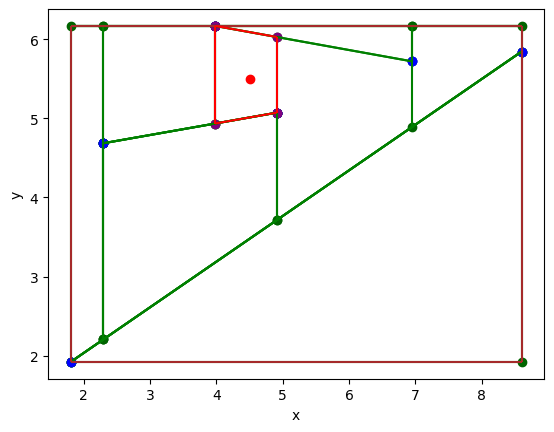

In [ ]:
%matplotlib inline
P = Point(4.5,5.5)
findPointVisualised(exampleLines1, P)

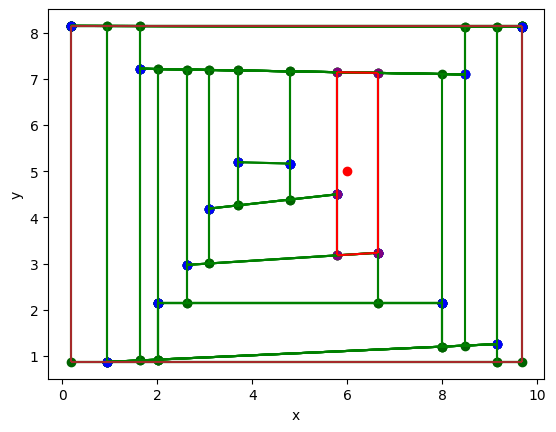

In [ ]:
%matplotlib inline
P = Point(6,5)
findPointVisualised(exampleLines2, P)

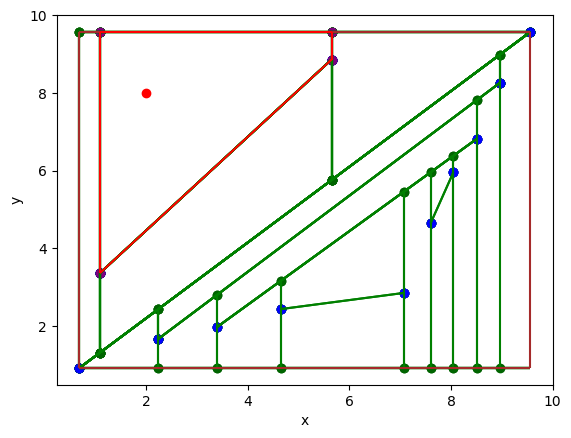

In [ ]:
%matplotlib inline
P = Point(2,8)
findPointVisualised(exampleLines3, P)

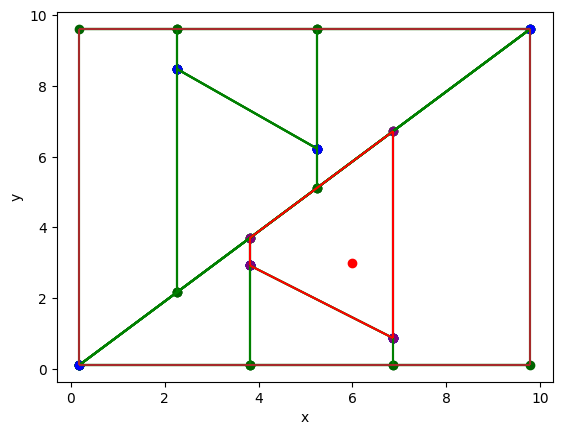

In [ ]:
%matplotlib inline
P = Point(6,3)
findPointVisualised(exampleLines4, P)

## Analiza efektywności algorytmu

Początkowo pod analizę efektywności poddano czas konsturkcji mapy trapezowej danej płaszczyzny. Do testów przygotowano różnoilościowe zbiory odcinków. W celu uzyskania rzeczywistej efektywności algorytmu, pominięto w tej części wizualizacje, która i tak w tych przypadkach byłaby bardzo nieczytelna ze względu na duże stężenie odcinków. Aby zastosować się do wszystkich założeń programu generowany były tylko odcinki o takich samych wartościach współrzędnej y dla obu końców, a różnych wartościach współrzędnych x.

In [ ]:
from time import time
from math import floor,ceil

sizes = [100, 500, 1000, 5000, 10000 ,25000, 50000, 75000]
x_max, y_max = 1000, 1000
trapezoidalMaps = []

borders = [((0, 0),(x_max, 0)),((0, y_max),(x_max, y_max))] 

for n in sizes:
    n-=2
    segments = [ ]
    divider = x_max / 2.0
    segments = []

    deltaX = deltaY = (x_max - divider) / (ceil(n/2) + 1)
    for i in range(1, ceil(n/2) + 1):
        segments.append(((i * deltaX, divider + deltaY), (x_max - i * deltaX, divider + deltaY)))

    deltaY = divider / (floor(n/2) + 1)
    for i in range(1, floor(n/2) + 1):
        segments.append((((i - 0.5) * deltaX, divider - deltaY), (x_max - (i - 0.5) * deltaX, divider - deltaY)))
    t1 = time()
    T = create_trapezoidal_map(segments + borders)
    t2 = time()
    trapezoidalMaps.append(T)
    print(" Liczba odcinków", n+2, "-> Czas budowy mapy: {ex_time:.4f} s".format(ex_time = t2 - t1))

### Rozmiar struktury przeszukiwań 

Do testów wydajnościowych także przeanalizowano rozmiar strkutry przeszukiwań, jako której rozmiar definujemy jako jejliczbę węzłów (wszystkich, nie tylko liści).

In [ ]:
def calculate_tree_size(node, count, visited):
    if node is None or node in visited:
        return
    count[0] += 1
    visited.add(node)
    calculate_tree_size(node.left, count, visited)
    calculate_tree_size(node.right, count, visited)

In [ ]:
for i in range(len(trapezoidalMaps)):
    size = [0]
    visited = set()
    T = trapezoidalMaps[i]
    calculate_tree_size(T.root, size, visited)
    print("Dla", sizes[i], "odcinków, rozmiar to:", size[0])

### Czas wyszukiwania lokalizacji punktu

Przeanlizowano także czas znajdowania trapezu, który zawiera wskazany punkt

In [ ]:
def generate_uniform_points(max_x, max_y, n):
    x_coord = np.random.uniform(1, max_x, n)
    y_coord = np.random.uniform(1, max_y, n)
    X = [(x, y) for x, y in zip(x_coord, y_coord)]
    Pints = []
    for x,y in X: Pints.append(Point(x,y))
    return Pints

In [ ]:
pointCount = 10000
for i in range(len(trapezoidalMaps)):
    P = generate_uniform_points(999, 999, pointCount)
    t1 = time()
    for p in P: trapezoidalMaps[i].query(trapezoidalMaps[i].root, p)
    t2 = time()
    print(f"Dla mapy {sizes[i]} odcinków, szukamy", pointCount, "punktów: {ex_time:.4f} s".format(ex_time = t2 - t1))